## Dimensionality reduction using Databricks

Dimensionality reduction is a process used in data science and machine learning to reduce the number of input variables (features) in a dataset while retaining as much meaningful information as possible. This is especially important when working with high-dimensional datasets where many features are redundant, irrelevant, or highly correlated.

Databricks provides a collaborative platform built on Apache Spark for running data analysis and machine learning workflows at scale.

## Step 1: Set Up PySpark in Colab

Install PySpark:

In [4]:
!wget -q https://dlcdn.apache.org/spark/spark-3.5.3/spark-3.5.3-bin-hadoop3.tgz


Unpack the Spark Archive:

In [6]:
!tar -xf spark-3.5.3-bin-hadoop3.tgz


Install PySpark Dependencies:

* Installs OpenJDK 8, required to run Spark.
* Installs the findspark library, which helps locate and initialize Spark in Python.

In [7]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!pip install -q findspark


Set Up Environment Variables:

In [10]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.5.3-bin-hadoop3"


Initialize PySpark

In [11]:
import findspark
findspark.init()
from pyspark.sql import SparkSession

spark = SparkSession.builder.master("local[*]").appName("DimensionalityReduction").getOrCreate()


## Step 2: Load Dataset into PySpark

Use a dataset compatible with Spark. For demonstration, we'll use the Wine Quality dataset.

Download the Dataset:

In [12]:
!wget -q https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv


Load into Spark DataFrame:

In [13]:
from pyspark.sql import DataFrameReader

wine_df = spark.read.csv("winequality-red.csv", header=True, inferSchema=True, sep=';')
wine_df.show(5)


+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+----+---------+-------+-------+
|fixed acidity|volatile acidity|citric acid|residual sugar|chlorides|free sulfur dioxide|total sulfur dioxide|density|  pH|sulphates|alcohol|quality|
+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+----+---------+-------+-------+
|          7.4|             0.7|        0.0|           1.9|    0.076|               11.0|                34.0| 0.9978|3.51|     0.56|    9.4|      5|
|          7.8|            0.88|        0.0|           2.6|    0.098|               25.0|                67.0| 0.9968| 3.2|     0.68|    9.8|      5|
|          7.8|            0.76|       0.04|           2.3|    0.092|               15.0|                54.0|  0.997|3.26|     0.65|    9.8|      5|
|         11.2|            0.28|       0.56|           1.9|    0.075|               17.0|           

## Step 3: Preprocess Data
Transform the data to a format suitable for dimensionality reduction.

Select Features:

In [14]:
from pyspark.ml.feature import VectorAssembler

feature_columns = [col for col in wine_df.columns if col != "quality"]
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
assembled_df = assembler.transform(wine_df)


Standardize the Data:

Standardizes features by scaling them to have zero mean and unit variance, a requirement for PCA.

In [15]:
from pyspark.ml.feature import StandardScaler

scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures")
scaler_model = scaler.fit(assembled_df)
scaled_df = scaler_model.transform(assembled_df)


## Step 4: Apply Dimensionality Reduction
Perform PCA (Principal Component Analysis) using Spark MLlib.

Apply PCA: PCA projects the original high-dimensional data onto 2D space while retaining maximum variance.

In [16]:
from pyspark.ml.feature import PCA

pca = PCA(k=2, inputCol="scaledFeatures", outputCol="pcaFeatures")
pca_model = pca.fit(scaled_df)
pca_result = pca_model.transform(scaled_df)
pca_result.show(5)


+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+----+---------+-------+-------+--------------------+--------------------+--------------------+
|fixed acidity|volatile acidity|citric acid|residual sugar|chlorides|free sulfur dioxide|total sulfur dioxide|density|  pH|sulphates|alcohol|quality|            features|      scaledFeatures|         pcaFeatures|
+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+----+---------+-------+-------+--------------------+--------------------+--------------------+
|          7.4|             0.7|        0.0|           1.9|    0.076|               11.0|                34.0| 0.9978|3.51|     0.56|    9.4|      5|[7.4,0.7,0.0,1.9,...|[4.25019565141442...|[-200.52300791552...|
|          7.8|            0.88|        0.0|           2.6|    0.098|               25.0|                67.0| 0.9968| 3.2|     0.68|    9.8|      5

PCA Parameters:
* k=2: Reduce dimensions to 2 principal components.
* inputCol: The column containing the scaled features.
* outputCol: The column where PCA features are stored.

Extract PCA Results: Converts the PCA-transformed data into a format suitable for further processing (e.g., visualization).

In [17]:
pca_data = pca_result.select("pcaFeatures").rdd.map(lambda row: row[0].toArray()).collect()


## Step 5: Visualize the Results
Use Matplotlib to visualize the PCA results.



Convert PCA Data to Pandas:

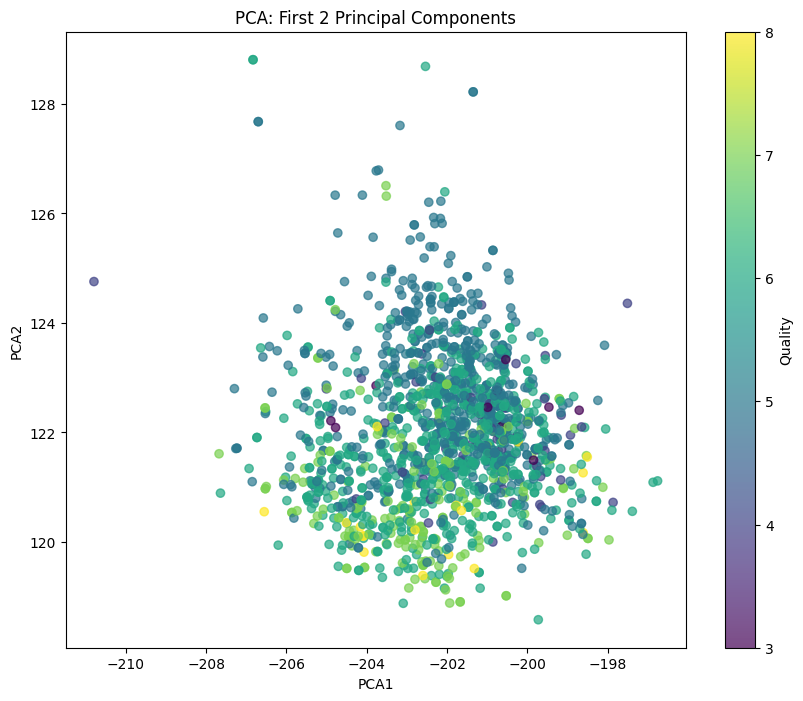

In [18]:
import pandas as pd
import matplotlib.pyplot as plt

pca_df = pd.DataFrame(pca_data, columns=["PCA1", "PCA2"])
pca_df["quality"] = wine_df.select("quality").toPandas()

plt.figure(figsize=(10, 8))
scatter = plt.scatter(pca_df["PCA1"], pca_df["PCA2"], c=pca_df["quality"], cmap="viridis", alpha=0.7)
plt.colorbar(scatter, label="Quality")
plt.title("PCA: First 2 Principal Components")
plt.xlabel("PCA1")
plt.ylabel("PCA2")
plt.show()


## Step 6: Run t-SNE
For t-SNE or other techniques not available in Spark, export the scaled data to NumPy and use scikit-learn.

Export Scaled Data:

In [20]:
!pip install numpy

t-SNE Parameters:
* n_components=2: Reduce data to 2D.
* perplexity=30: Determines the balance between local and global views.
* n_iter=300: Number of optimization iterations.
random_state=42: Ensures reproducibility.

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


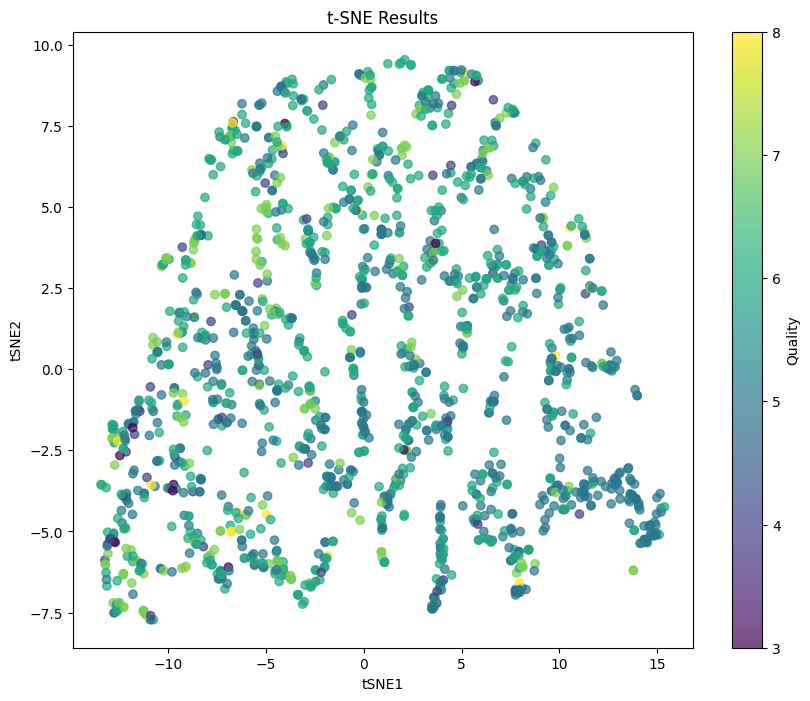

In [38]:
from sklearn.manifold import TSNE
import pandas as pd
import matplotlib.pyplot as plt

# Convert PySpark DataFrame to Pandas DataFrame
pandas_df = wine_df.toPandas()

# Separate features and labels
numpy_data = pandas_df.drop(columns=["quality"]).values  # Convert features to NumPy array
labels = pandas_df["quality"].values  # Extract quality labels

# Apply t-SNE
tsne = TSNE(n_components=2, perplexity=30, n_iter=300, random_state=42)
tsne_result = tsne.fit_transform(numpy_data)

# Create a DataFrame for visualization
tsne_df = pd.DataFrame(tsne_result, columns=["tSNE1", "tSNE2"])
tsne_df["quality"] = labels

# Plot the t-SNE results
plt.figure(figsize=(10, 8))
scatter = plt.scatter(tsne_df["tSNE1"], tsne_df["tSNE2"], c=tsne_df["quality"], cmap="viridis", alpha=0.7)
plt.colorbar(scatter, label="Quality")
plt.title("t-SNE Results")
plt.xlabel("tSNE1")
plt.ylabel("tSNE2")
plt.show()


In [26]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


## Visualization 1: Two-dimensional Gaussians
Generate and visualize Gaussian-distributed data.

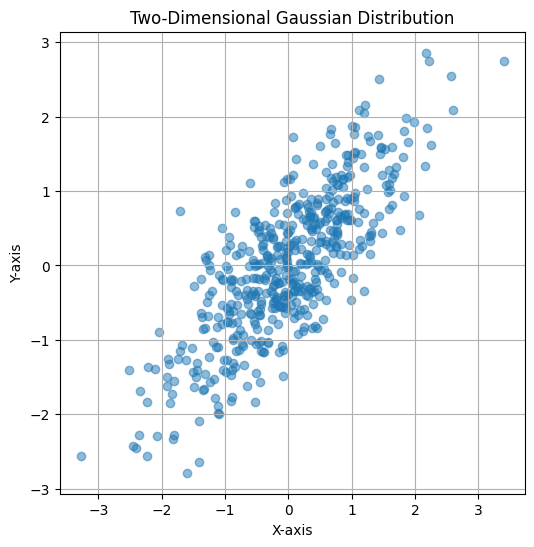

In [27]:
# Generate two-dimensional Gaussian data
np.random.seed(42)
mean = [0, 0]
cov = [[1, 0.8], [0.8, 1]]  # covariance matrix
data = np.random.multivariate_normal(mean, cov, 500)

# Scatter plot of Gaussian data
plt.figure(figsize=(6, 6))
plt.scatter(data[:, 0], data[:, 1], alpha=0.5)
plt.title("Two-Dimensional Gaussian Distribution")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.grid()
plt.show()


The resulting plot visualizes the 2D Gaussian distribution:

1. Shape:The points form an elliptical cluster centered around (0, 0), reflecting the specified mean.
The spread (elongation of the ellipse) is influenced by the covariance matrix.
2. Covariance Impact:The positive covariance (0.8) causes the points to cluster along a diagonal direction from the lower left to the upper right. This indicates a positive relationship between the two dimensions.
3. Density:Points are denser near the mean (center), gradually thinning out as they move away, following the Gaussian bell curve pattern.

Part 2: Write a PCA Function and Evaluate PCA on Sample Datasets

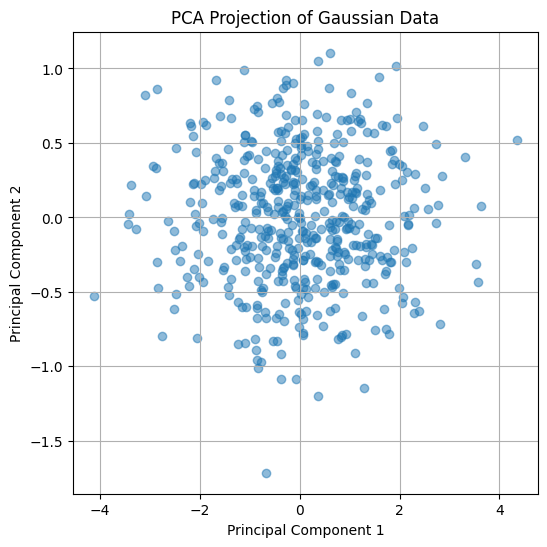

In [28]:
# Define a custom PCA function
def perform_pca(data, n_components=2):
    pca = PCA(n_components=n_components)
    principal_components = pca.fit_transform(data)
    return pca, principal_components

# Evaluate PCA on the Gaussian dataset
pca, pca_data = perform_pca(data)

# Visualize the PCA projection
plt.figure(figsize=(6, 6))
plt.scatter(pca_data[:, 0], pca_data[:, 1], alpha=0.5)
plt.title("PCA Projection of Gaussian Data")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.grid()
plt.show()


## Visualization 2: PCA Projection

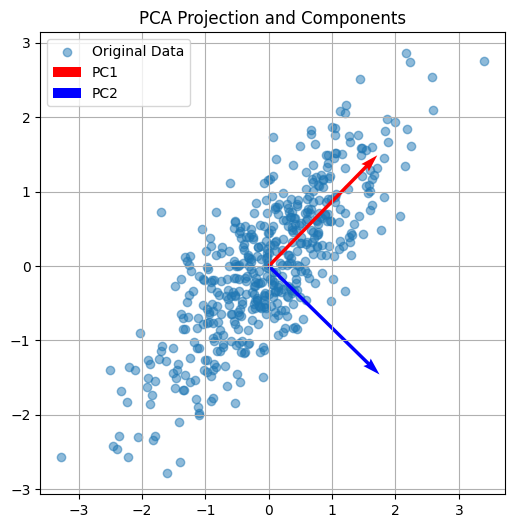

In [29]:
# Plot original data with PCA components
plt.figure(figsize=(6, 6))
plt.scatter(data[:, 0], data[:, 1], alpha=0.5, label="Original Data")
plt.quiver(0, 0, pca.components_[0, 0], pca.components_[0, 1], color="r", scale=3, label="PC1")
plt.quiver(0, 0, pca.components_[1, 0], pca.components_[1, 1], color="b", scale=3, label="PC2")
plt.legend()
plt.title("PCA Projection and Components")
plt.grid()
plt.show()


The results of the plot:
1. PCA simplifies the dataset by reorienting it along directions of maximum variance.
2. In higher dimensions, such projections allow us to visualize and analyze complex datasets in a lower-dimensional space.
3. The projection ensures that minimal information is lost, preserving the overall structure of the data.

## Visualization 3: Three-dimensional Data

This plot visualizes three-dimensional Gaussian-distributed data generated using a specified mean and covariance matrix. The 3D scatter plot provides insights into how the data is distributed in 3D space.


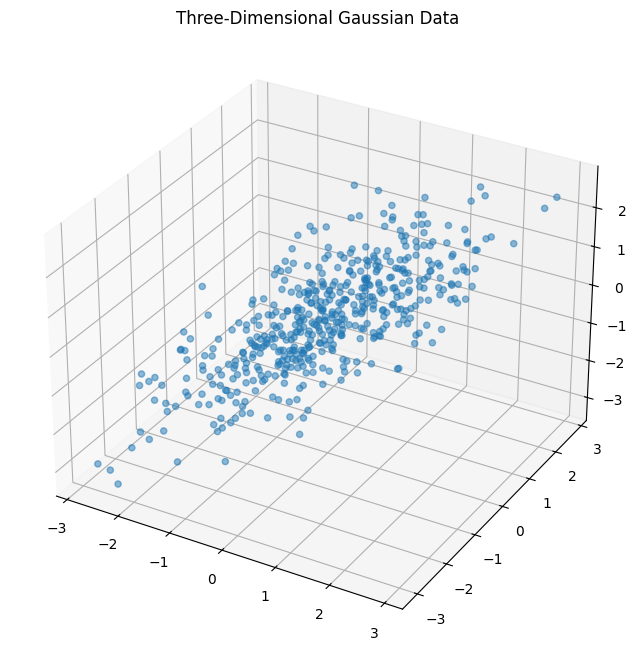

In [30]:
# Generate 3D Gaussian data
mean_3d = [0, 0, 0]
cov_3d = [[1, 0.8, 0.6], [0.8, 1, 0.8], [0.6, 0.8, 1]]
data_3d = np.random.multivariate_normal(mean_3d, cov_3d, 500)

# 3D Scatter plot
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(data_3d[:, 0], data_3d[:, 1], data_3d[:, 2], alpha=0.5)
ax.set_title("Three-Dimensional Gaussian Data")
plt.show()


The results of this plot:
1. Provides a clear understanding of how data is distributed in three dimensions.
2. Useful for exploring relationships between dimensions in higher-dimensional datasets.
3. Sets the stage for dimensionality reduction techniques like PCA, which simplify such datasets by projecting them into lower-dimensional spaces.

## Visualization 4: 2D Representation of 3D Data

This plot represents the 2D projection of 3D data using Principal Component Analysis (PCA). The transformation reduces the original three-dimensional dataset into two principal components while retaining most of the variance in the data.

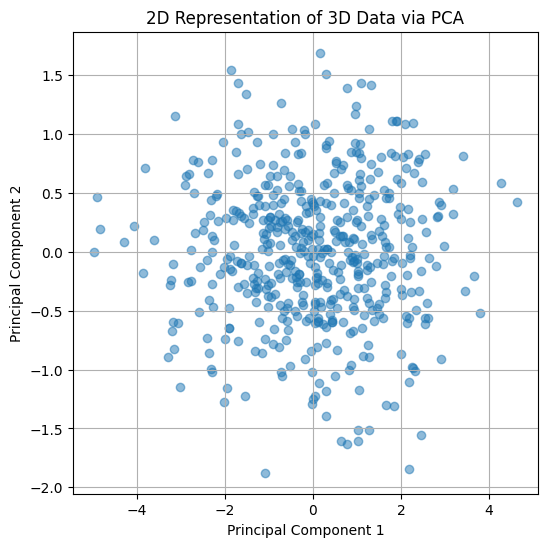

In [31]:
# PCA on 3D data
pca_3d, pca_data_3d = perform_pca(data_3d, n_components=2)

# 2D projection
plt.figure(figsize=(6, 6))
plt.scatter(pca_data_3d[:, 0], pca_data_3d[:, 1], alpha=0.5)
plt.title("2D Representation of 3D Data via PCA")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.grid()
plt.show()


This plot:

1. Simplification: Reduces 3D data into a 2D representation for easier visualization and analysis.
2. Insights into Variance: Highlights the directions with the most significant variance, making the data more interpretable.
3. Feature Reduction: Demonstrates how PCA can effectively reduce dimensionality without losing critical information.

## Visualization 5: Pixel Intensity

This plot visualizes the pixel intensity values of a single digit from the digits dataset, a well-known dataset from scikit-learn for machine learning and image processing tasks. The goal is to display the grayscale representation of the digit.

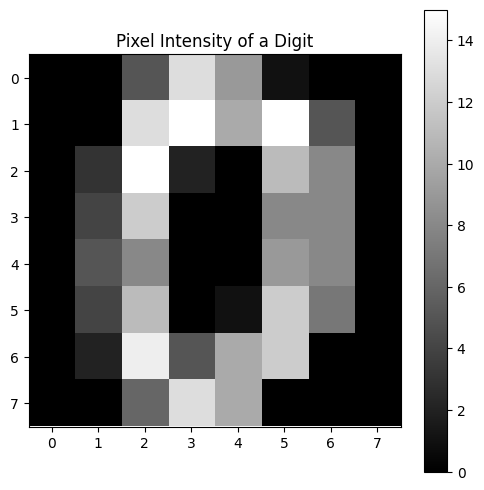

In [32]:
from sklearn.datasets import load_digits

# Load digit dataset
digits = load_digits()
images = digits.images
flat_data = digits.data

# Display one digit
plt.figure(figsize=(6, 6))
plt.imshow(images[0], cmap="gray")
plt.title("Pixel Intensity of a Digit")
plt.colorbar()
plt.show()


## Visualization 6: Normalized Data

This plot shows the 2D projection of normalized digit data using Principal Component Analysis (PCA). It visualizes how PCA reduces the dimensionality of the high-dimensional digit data while preserving the essential patterns.

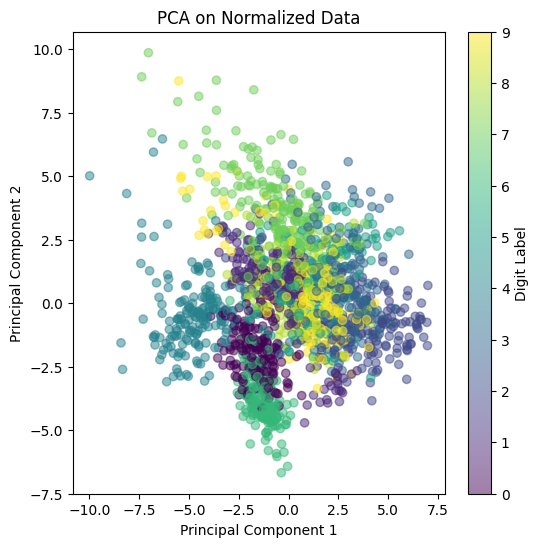

In [33]:
# Normalize the data
scaler = StandardScaler()
normalized_data = scaler.fit_transform(flat_data)

# PCA on normalized data
pca_digits, pca_data_digits = perform_pca(normalized_data, n_components=2)

# Scatter plot
plt.figure(figsize=(6, 6))
plt.scatter(pca_data_digits[:, 0], pca_data_digits[:, 1], c=digits.target, cmap="viridis", alpha=0.5)
plt.title("PCA on Normalized Data")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.colorbar(label="Digit Label")
plt.show()


Key Observations from the Plot:
1. Clusters: Points form distinct clusters corresponding to different digit labels (0–9).PCA effectively captures patterns in the data, even with dimensionality reduced to 2.
2. Separation: Digits with more unique pixel patterns (e.g., "1" vs. "8") are well-separated. Digits with similar pixel patterns (e.g., "3" and "8") may overlap slightly, as PCA does not explicitly maximize class separation.
3. Explained Variance: The first two principal components capture most of the variance in the digit data, reducing redundancy in features.

## Visualization 7: Top Two Components as Images

This visualization shows the top two principal components (PCA components) as 8x8 grayscale images. These components correspond to the directions in the high-dimensional pixel space that capture the most significant variance across all the digit images.

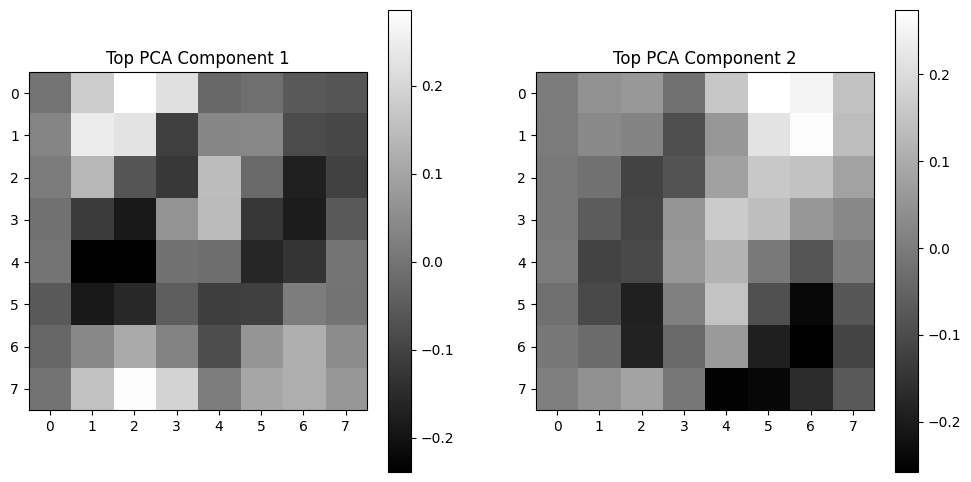

In [34]:
# Display top two PCA components
components = pca_digits.components_

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(components[0].reshape(8, 8), cmap="gray")
plt.title("Top PCA Component 1")
plt.colorbar()

plt.subplot(1, 2, 2)
plt.imshow(components[1].reshape(8, 8), cmap="gray")
plt.title("Top PCA Component 2")
plt.colorbar()
plt.show()


* These plots reveal the regions of the digit images that vary the most, helping us understand how PCA reduces the dataset's complexity.
* The components provide an interpretable summary of the data, representing it in terms of the most important patterns

## Visualization 8: Top Two Components as One Image

This visualization shows the combined image of the top two PCA components, created by adding the first and second principal components together. The resulting image provides a composite representation of the most significant patterns in the dataset as identified by PCA.

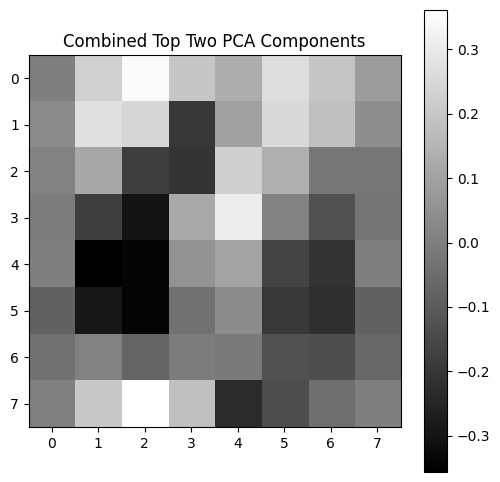

In [35]:
# Combine components into one image
combined_image = components[0] + components[1]

plt.figure(figsize=(6, 6))
plt.imshow(combined_image.reshape(8, 8), cmap="gray")
plt.title("Combined Top Two PCA Components")
plt.colorbar()
plt.show()


## Part 4: Feature-Based Aggregation Followed by PCA

This visualization shows the PCA projection of aggregated digit features. The dataset is aggregated by digit labels (0–9), where the mean feature values for each digit are computed. PCA is then applied to reduce the dimensionality of these aggregated features to two dimensions for visualization.

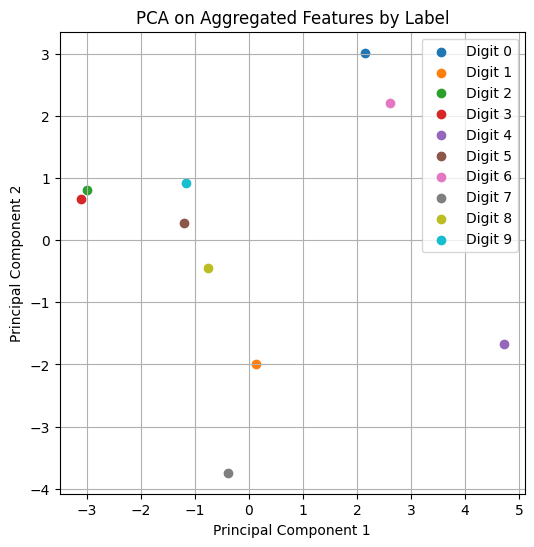

In [37]:
import pandas as pd

# Convert normalized data to a DataFrame with labels
normalized_df = pd.DataFrame(normalized_data)
normalized_df['label'] = digits.target

# Group by the digit label and calculate the mean for each feature
aggregated_data = normalized_df.groupby('label').mean()

# Apply PCA on the aggregated data
pca_agg, pca_data_agg = perform_pca(aggregated_data.values, n_components=2)

# Visualization
plt.figure(figsize=(6, 6))
for i, label in enumerate(aggregated_data.index):
    plt.scatter(pca_data_agg[i, 0], pca_data_agg[i, 1], label=f'Digit {label}')
plt.title("PCA on Aggregated Features by Label")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()
plt.grid()
plt.show()
